In [1]:
import os
import pandas as pd
import duckdb
import matplotlib.pyplot as plt
from pathlib import Path
import numpy as np

con = duckdb.connect()


In [2]:
project_root = Path.cwd().parent
games_path = project_root/"out"/"cleaned_games"

In [3]:
query = f"""
CREATE OR REPlACE VIEW games AS
SELECT game_id, game_datetime, white, black, result, game_type
FROM parquet_scan('{games_path}/*.parquet')
"""

con.execute(query)

In [4]:
sql_file = Path(r"sql/streaks.sql")
query = sql_file.read_text()

streaks_df = con.execute(query).fetchdf()

FloatProgress(value=0.0, layout=Layout(width='auto'), style=ProgressStyle(bar_color='black'))

In [5]:
sql_file = Path(r"sql/lossrate.sql")
query = sql_file.read_text()

lossrate_df = con.execute(query).fetchdf()

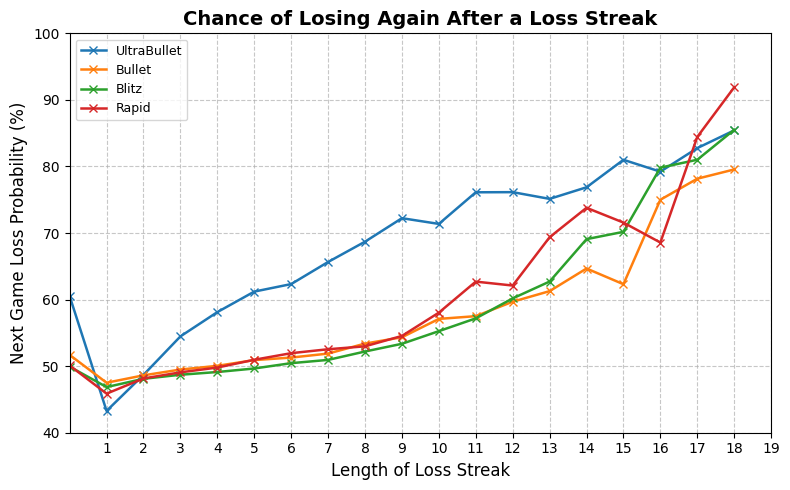

In [18]:
max_streak = 19

game_type = "Blitz"

game_types = ["UltraBullet", "Bullet", "Blitz", "Rapid"]

colours = {
    "Classical":"#9467bd",
    "Rapid":"#d62728",
    "Blitz":"#2ca02c",
    "Bullet":"#ff7f0e",
    "UltraBullet":"#1f77b4",
}

df_shortened = streaks_df[streaks_df["losses_in_streak_before"] < max_streak]
df_plotting = df_shortened[df_shortened["game_type"] == game_type]

fig, ax = plt.subplots(figsize=(8, 5))

# Set flag for if lossrate line should be plotted
lossrate = False

# Plot data for each game type and its horizontal loss-rate line
for gt in game_types:
    df_gt = df_shortened[df_shortened["game_type"] == gt]

    ax.plot(
        df_gt["losses_in_streak_before"],
        df_gt["next_loss_pct"],
        marker="x",
        linestyle="-",
        color=colours.get(gt, "#1f77b4"),
        linewidth=1.8,
        markersize=6,
        label=f"{gt}"
    )

    # draw horizontal loss-rate line for this game type (if present)
    if lossrate:
        draw_pct = lossrate_df.loc[lossrate_df["game_type"] == gt, "draw_pct"].iloc[0]
        ax.axhline(50 - draw_pct/2, color=colours.get(gt, "red"), linestyle="--", label=f"lossrate ({gt})")

# Titles and labels
ax.set_title("Chance of Losing Again After a Loss Streak", fontsize=14, weight="bold")
ax.set_xlabel("Length of Loss Streak", fontsize=12)
ax.set_ylabel("Next Game Loss Probability (%)", fontsize=12)

# Grid and ticks
ax.grid(True, linestyle="--", alpha=0.7)
ax.set_xlim(0, max_streak)
ax.set_xticks(range(1, max_streak+1))
ax.set_ylim(40, 100)
ax.set_yticks(range(40, 101, 10))

ax.legend(loc="best", fontsize=9)

# Tight layout and show
plt.tight_layout()
plt.show()